In [24]:
from __future__ import print_function

from collections import defaultdict
import operator
from time import time

import numpy as np

from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.externals.six import iteritems
from sklearn.datasets.twenty_newsgroups import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import v_measure_score

import pandas as pd

from matplotlib import pyplot as plt

from sklearn.datasets import make_checkerboard
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import consensus_score

from sklearn.datasets import make_biclusters
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import consensus_score

%matplotlib inline

In [32]:
# dataset nuevo 
website_url = './datasets_recsys/ff_users_fav_stories_data.csv'
ff_data = pd.read_csv(website_url, sep='|', index_col=None, encoding='latin') # This may take a couple minutes
ff_data = ff_data[['user','story_id']]
ff_data.values.tolist()

[[752508, 1984041],
 [752508, 2046469],
 [752508, 1991603],
 [752508, 2179554],
 [752508, 1879281],
 [752508, 2112786],
 [752508, 2102221],
 [752508, 2060423],
 [752508, 1878043],
 [798312, 1878043],
 [2611362, 10745870],
 [4384491, 10745870],
 [7689144, 10745870],
 [2611362, 5623479],
 [2611362, 6597848],
 [2611362, 5047014],
 [2611362, 8774931],
 [2611362, 6530889],
 [2611362, 6601509],
 [2611362, 6661447],
 [2611362, 5216883],
 [2611362, 6612272],
 [2611362, 6487775],
 [2611362, 6576263],
 [2611362, 6530875],
 [2611362, 6434954],
 [2611362, 6375158],
 [2611362, 6303132],
 [2611362, 6122115],
 [2611362, 6090758],
 [2611362, 5809190],
 [2611362, 5584255],
 [2611362, 5544903],
 [2611362, 5401954],
 [2611362, 5078671],
 [2611362, 5210720],
 [2611362, 5189196],
 [4536257, 8292435],
 [4536257, 9730950],
 [4536257, 9584936],
 [6688423, 9584936],
 [4536257, 10993379],
 [4536257, 8833003],
 [6269551, 8833003],
 [4287711, 8833003],
 [4536257, 9129532],
 [6756413, 9129532],
 [5441831, 9129532]

Vectorizing...


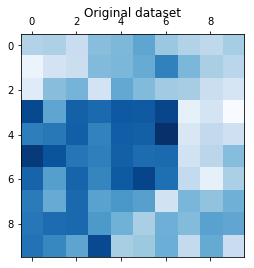

In [23]:
n_clusters = 3
data, rows, columns = make_checkerboard(
    shape=(10, 10), n_clusters=n_clusters, noise=10,
    shuffle=False, random_state=0)

plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Original dataset")


In [12]:
data, rows, columns = make_biclusters(
    shape=(300, 300), n_clusters=5, noise=5,
    shuffle=False, random_state=0)

In [16]:
columns

array([[ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True]], dtype=bool)

In [17]:
from __future__ import print_function

from collections import defaultdict
import operator
from time import time

import numpy as np

from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.externals.six import iteritems
from sklearn.datasets.twenty_newsgroups import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import v_measure_score

print(__doc__)


def number_normalizer(tokens):
    """ Map all numeric tokens to a placeholder.
    For many applications, tokens that begin with a number are not directly
    useful, but the fact that such a token exists can be relevant.  By applying
    this form of dimensionality reduction, some methods may perform better.
    """
    return ("#NUMBER" if token[0].isdigit() else token for token in tokens)


class NumberNormalizingVectorizer(TfidfVectorizer):
    def build_tokenizer(self):
        tokenize = super(NumberNormalizingVectorizer, self).build_tokenizer()
        return lambda doc: list(number_normalizer(tokenize(doc)))


# exclude 'comp.os.ms-windows.misc'
categories = ['alt.atheism', 'comp.graphics',
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'comp.windows.x', 'misc.forsale', 'rec.autos',
              'rec.motorcycles', 'rec.sport.baseball',
              'rec.sport.hockey', 'sci.crypt', 'sci.electronics',
              'sci.med', 'sci.space', 'soc.religion.christian',
              'talk.politics.guns', 'talk.politics.mideast',
              'talk.politics.misc', 'talk.religion.misc']

newsgroups = fetch_20newsgroups(categories=categories)
y_true = newsgroups.target

vectorizer = NumberNormalizingVectorizer(stop_words='english', min_df=5)
cocluster = SpectralCoclustering(n_clusters=len(categories),
                                 svd_method='arpack', random_state=0)

kmeans = MiniBatchKMeans(n_clusters=len(categories), batch_size=20000,
                         random_state=0)

print("Vectorizing...")
X = vectorizer.fit_transform(newsgroups.data)

print("Coclustering...")
start_time = time()
cocluster.fit(X)
y_cocluster = cocluster.row_labels_
print("Done in {:.2f}s. V-measure: {:.4f}".format(
    time() - start_time,
    v_measure_score(y_cocluster, y_true)))

print("MiniBatchKMeans...")
start_time = time()
y_kmeans = kmeans.fit_predict(X)
print("Done in {:.2f}s. V-measure: {:.4f}".format(
    time() - start_time,
    v_measure_score(y_kmeans, y_true)))

feature_names = vectorizer.get_feature_names()
document_names = list(newsgroups.target_names[i] for i in newsgroups.target)


def bicluster_ncut(i):
    rows, cols = cocluster.get_indices(i)
    if not (np.any(rows) and np.any(cols)):
        import sys
        return sys.float_info.max
    row_complement = np.nonzero(np.logical_not(cocluster.rows_[i]))[0]
    col_complement = np.nonzero(np.logical_not(cocluster.columns_[i]))[0]
    # Note: the following is identical to X[rows[:, np.newaxis],
    # cols].sum() but much faster in scipy <= 0.16
    weight = X[rows][:, cols].sum()
    cut = (X[row_complement][:, cols].sum() +
           X[rows][:, col_complement].sum())
    return cut / weight


def most_common(d):
    """Items of a defaultdict(int) with the highest values.
    Like Counter.most_common in Python >=2.7.
    """
    return sorted(iteritems(d), key=operator.itemgetter(1), reverse=True)


bicluster_ncuts = list(bicluster_ncut(i)
                       for i in range(len(newsgroups.target_names)))
best_idx = np.argsort(bicluster_ncuts)[:5]

print()
print("Best biclusters:")
print("----------------")
for idx, cluster in enumerate(best_idx):
    n_rows, n_cols = cocluster.get_shape(cluster)
    cluster_docs, cluster_words = cocluster.get_indices(cluster)
    if not len(cluster_docs) or not len(cluster_words):
        continue

    # categories
    counter = defaultdict(int)
    for i in cluster_docs:
        counter[document_names[i]] += 1
    cat_string = ", ".join("{:.0f}% {}".format(float(c) / n_rows * 100, name)
                           for name, c in most_common(counter)[:3])

    # words
    out_of_cluster_docs = cocluster.row_labels_ != cluster
    out_of_cluster_docs = np.where(out_of_cluster_docs)[0]
    word_col = X[:, cluster_words]
    word_scores = np.array(word_col[cluster_docs, :].sum(axis=0) -
                           word_col[out_of_cluster_docs, :].sum(axis=0))
    word_scores = word_scores.ravel()
    important_words = list(feature_names[cluster_words[i]]
                           for i in word_scores.argsort()[:-11:-1])

    print("bicluster {} : {} documents, {} words".format(
        idx, n_rows, n_cols))
    print("categories   : {}".format(cat_string))
    print("words        : {}\n".format(', '.join(important_words)))

Automatically created module for IPython interactive environment
Vectorizing...
Coclustering...
Done in 3.91s. V-measure: 0.4435
MiniBatchKMeans...
Done in 6.55s. V-measure: 0.3344

Best biclusters:
----------------
bicluster 0 : 1957 documents, 4363 words
categories   : 23% talk.politics.guns, 18% talk.politics.misc, 17% sci.med
words        : gun, guns, geb, banks, gordon, clinton, pitt, cdt, surrender, veal

bicluster 1 : 1263 documents, 3551 words
categories   : 27% soc.religion.christian, 25% talk.politics.mideast, 24% alt.atheism
words        : god, jesus, christians, sin, objective, kent, belief, christ, faith, moral

bicluster 2 : 2212 documents, 2774 words
categories   : 18% comp.sys.mac.hardware, 17% comp.sys.ibm.pc.hardware, 15% comp.graphics
words        : voltage, board, dsp, stereo, receiver, packages, shipping, circuit, package, compression

bicluster 3 : 1774 documents, 2629 words
categories   : 27% rec.motorcycles, 23% rec.autos, 13% misc.forsale
words        : bike, c

In [20]:
newsgroups

{'DESCR': None,
 'data': ["From: cst@blueoak.berkeley.edu (Courtney Terry)\nSubject: For Sale: 1969 karmann ghia\nOrganization: University of California, Berkeley\nLines: 25\nDistribution: ba\nNNTP-Posting-Host: blueoak.berkeley.edu\n\n*******************************************************\n                   1969 karmann ghia\n*******************************************************\n\nThis car is in excellent running condition:\n               *********\n  *49,000 mi on new engine\n  *new tires (Aug 92)\n  *new clutch (91)\n  *new carb (91)\n  *original radio (am/fm)\n  *upholstery in great shape\n  *burgundy exterior/ black interior\n\nThis car has been well-maintained with regular tune-ups.\nUnfortunately, the car's previous owner had a minor\nfront-end collision.  The right front nose is dented\nand patched up with bondo.  I have the hard-to-find part\nneeded to repair this damage.  Besides that damage, the car\nis in excellent condition. $1600/bo\n\nCourtney  email: cst@blueoak.b

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster.bicluster import SpectralCoclustering
import requests
import time

url_base = "http://www.gutenberg.org/cache/epub/{0}/pg{0}.txt"
ids = [1228, 22728, 5273, 19192, 2926, 2929, 6475, 20818, 24648,
       22428, 35937, 27477, 6630, 15636, 35744, 26556, 6574, 28247,
       25992, 28613]
docs = []
for i in ids:
    docs.append(requests.get(url_base.format(i)).text)
    time.sleep(30)  # be nice to the server

vec = TfidfVectorizer(stop_words='english')
model = SpectralCoclustering(n_clusters=2, svd_method='arpack')
data = vec.fit_transform(docs).T
model.fit(data)

SpectralCoclustering(init='k-means++', mini_batch=False, n_clusters=2,
           n_init=10, n_jobs=1, n_svd_vecs=None, random_state=None,
           svd_method='arpack')